# Global ECMWF Fire Forecasting - ERA-Interim based reanalysis of the Fire Weather Index

Import the necessary libraries and enable inline displaying of plots

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline

### Get data

Explore the list of available fire danger indices on the Zenodo repository (wildfire community): https://zenodo.org/communities/wildfire. 

Go to FWI and download ‘fwi.nc’.

In [2]:
# Open fwi.nc as dataset
ds = xr.open_dataset("/home/claudia/Downloads/fwi.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, time: 14061)
Coordinates:
  * lon      (lon) float32 -180.0 -179.29688 -178.59375 ... 178.59375 179.29688
  * lat      (lat) float32 89.46282 88.76695 88.06697 ... -88.76695 -89.46282
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-06-30
Data variables:
    fwi      (time, lat, lon) float32 ...
Attributes:
    CDI:               Climate Data Interface version 1.8.2 (http://mpimet.mp...
    history:           Fri Aug 31 16:18:06 2018: cdo cat /hugetmp/fire/geff/r...
    Conventions:       CF-1.6
    Reference date:    19800101
    ECMWF fire model:  2.2
    Lincense:          Copernicus
    version:           2.2
    NCO:               4.6.7
    CDO:               Climate Data Operators version 1.8.2 (http://mpimet.mp...

In [3]:
# Convert ds to a dataarray extracting only the variable fwi
da = ds.fwi
da

<xarray.DataArray 'fwi' (time: 14061, lat: 256, lon: 512)>
[1843003392 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -180.0 -179.29688 -178.59375 ... 178.59375 179.29688
  * lat      (lat) float32 89.46282 88.76695 88.06697 ... -88.76695 -89.46282
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-06-30
Attributes:
    units:    -
    title:    Fire Weather Index

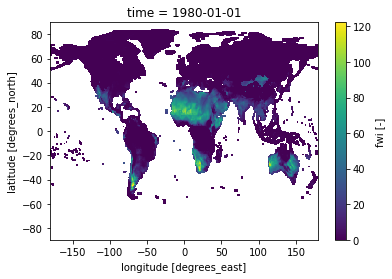

In [4]:
# Plot the first reanalysis layer (1980-01-01)
fwi = da[0]
fwi.plot();

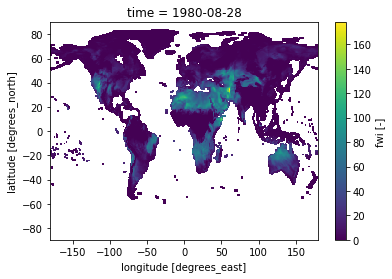

In [5]:
# Plot a reanalysis layer in August (1980-08-28)
fwi = da[30*8]
fwi.plot();

### Extract a sub-cube by slicing over three dimensions

In [6]:
fwi = da.loc[dict(time = slice('1980-01-01', '2017-12-31'), lat = slice(71.5, 54), lon = slice(4, 31.5))]
fwi

<xarray.DataArray 'fwi' (time: 13880, lat: 25, lon: 39)>
[13533000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 4.21875 4.921875 5.625 ... 29.53125 30.234375 30.9375
  * lat      (lat) float32 71.22775 70.52601 69.824265 ... 55.087563 54.385815
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2017-12-31
Attributes:
    units:    -
    title:    Fire Weather Index

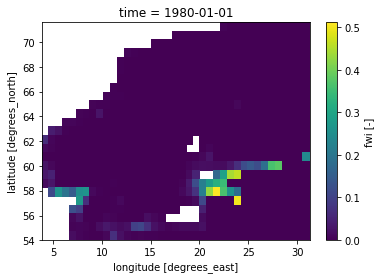

In [7]:
# Plot the first layer of the sub-cube
fwi[0,:,:].plot();

What is the mean value over the area for each day?

In [8]:
fwi_mean = fwi.mean(dim = ('lon', 'lat'))

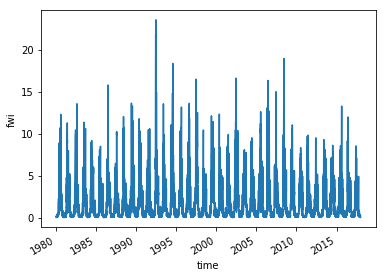

In [9]:
# Plot the mean value over the whole period
fwi_mean.plot();

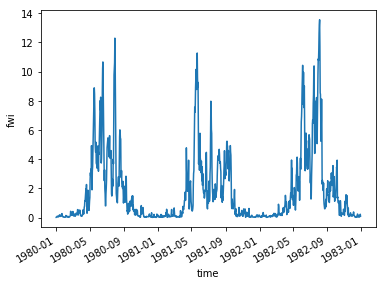

In [10]:
# Plot the mean value over the first three years
fwi_mean[0:3*365].plot();

### Fixed Danger Levels

Some examples:

* JRC thresholds for Europe: Very Low = 0-5.2, Low =5.2-11.2, Moderate = 11.2-21.3, High = 21.3-38.0, Very High = 38-50.0, Extreme = >50
* CANADA: Very Low = 0-1, Low = 2-4, Moderate=5-8, High=9-16, VeryHigh=17-30, Extreme=>30
* Portugal: Reduced risk = 8.4, moderate risk = 17.2, high risk = 24.6, maximum risk = 38.3

### Regional Danger Levels

In [116]:
# Define percentiles of interest to generate danger threshold maps
fire_percentiles = [0.50, 0.75, 0.85, 0.90, 0.95, 0.98]

In [16]:
# Calculate the maps of percentiles as threshold of danger
danger_threshold_maps = fwi.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)

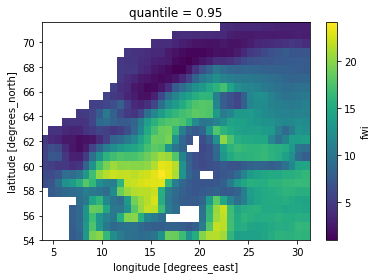

In [21]:
# Plot map of 95th percentile
danger_threshold_maps[4,:,:].plot();

In [25]:
# Obtain fixed set of thresholds as the median over the area for each time step (as integer)
# Very low = 0
# Low = 1
# Moderate = 4
# High = 6
# Very high = 10
# Extreme = 14
danger_threshold_maps.median(dim=('lon', 'lat')).astype(int)

<xarray.DataArray 'fwi' (quantile: 6)>
array([ 0,  1,  4,  6, 10, 14])
Coordinates:
  * quantile  (quantile) float64 0.5 0.75 0.85 0.9 0.95 0.98

### Danger Levels based on the daily fire climatology

Let's assume we want to estimate danger level maps for 10th July

In [106]:
# Find indices of dates corresponding to 10th July
idx = np.concatenate(np.where((fwi.time.dt.day == 10) & (fwi.time.dt.month == 7)))

Let's expand this range of indices to include 4 days before and after each date

In [101]:
indices_list = []
for i in idx:
    indices_list.append(list(range(i - 4, i + 4 + 1)))

In [112]:
# Concatenate all the indices in a 1-dimensional array
indices = np.concatenate(indices_list)

In [122]:
# Calculate the maps of percentiles as threshold of danger
fwi10July = fwi[indices,:,:]
daily_danger_threshold_maps = fwi10July.quantile(q = fire_percentiles, dim = 'time', keep_attrs = True)

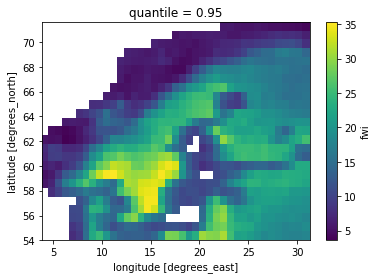

In [124]:
# Plot the map of 95th percentile as threshold of VERY HIGH danger
daily_danger_threshold_maps[4].plot();